In [21]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200

nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


In [0]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [24]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

In [25]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


# Implementing the Continuous Bag of Words (CBOW) Model

In [26]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


In [27]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


 We have input context words of dimensions (2 x window_size), we will pass them to an embedding layer of size (vocab_size x embed_size) which will give us dense word embeddings for each of these context words (1 x embed_size for each word). Next up we use a lambda layer to average out these embeddings and get an average dense embedding (1 x embed_size) which is sent to the dense softmax layer which outputs the most likely target word

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 100)            1242500   
_________________________________________________________________
lambda_2 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12425)             1254925   
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


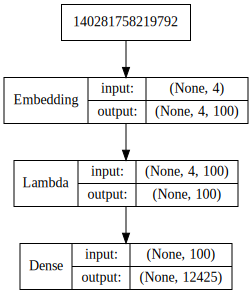

In [28]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [0]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

W0709 08:31:42.742135 140282599458688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0709 08:31:42.825945 140282599458688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 1 	Loss: 4050756.948550253

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 2 	Loss: 4268616.118638222

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 3 	Loss: 4195168.6296006115



In [0]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()